In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import string
import os
import nltk
import time
import re
import pickle

start_time = time.time()

from nltk.stem.porter import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction import stop_words

from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_notebook

sns.set()
warnings.filterwarnings("ignore")

PATH = "/work/kaggle_practice/Mercari/input"

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
os.chdir("/work/kaggle_practice/Mercari/input/")
train = pd.read_csv("train.tsv", delimiter="\t")
test = pd.read_csv("test.tsv", delimiter="\t")
print("Finished load data:{}".format(time.time() - start_time))

Finished load data:31.739758491516113


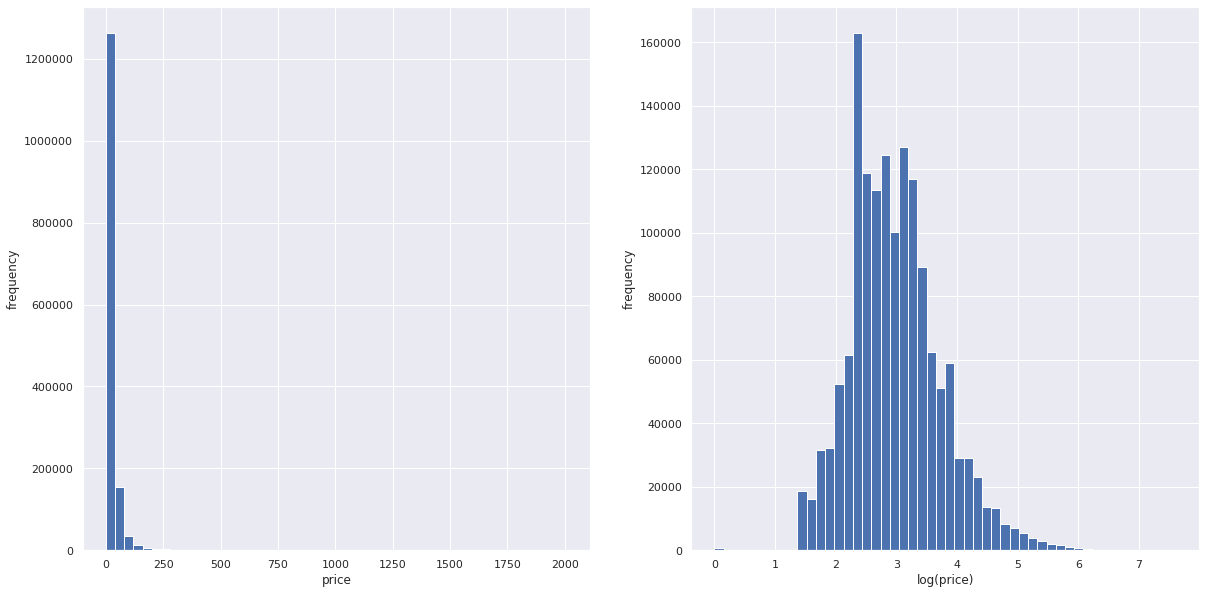

In [32]:
plt.subplot(1, 2, 1)
train["price"].plot.hist(bins=50, figsize=(20, 10))
plt.xlabel("price")
plt.ylabel("frequency")

plt.subplot(1 ,2 ,2)
np.log(train["price"]+1).plot.hist(bins=50, figsize=(20, 10))
plt.xlabel("log(price)")
plt.ylabel("frequency")
plt.show()

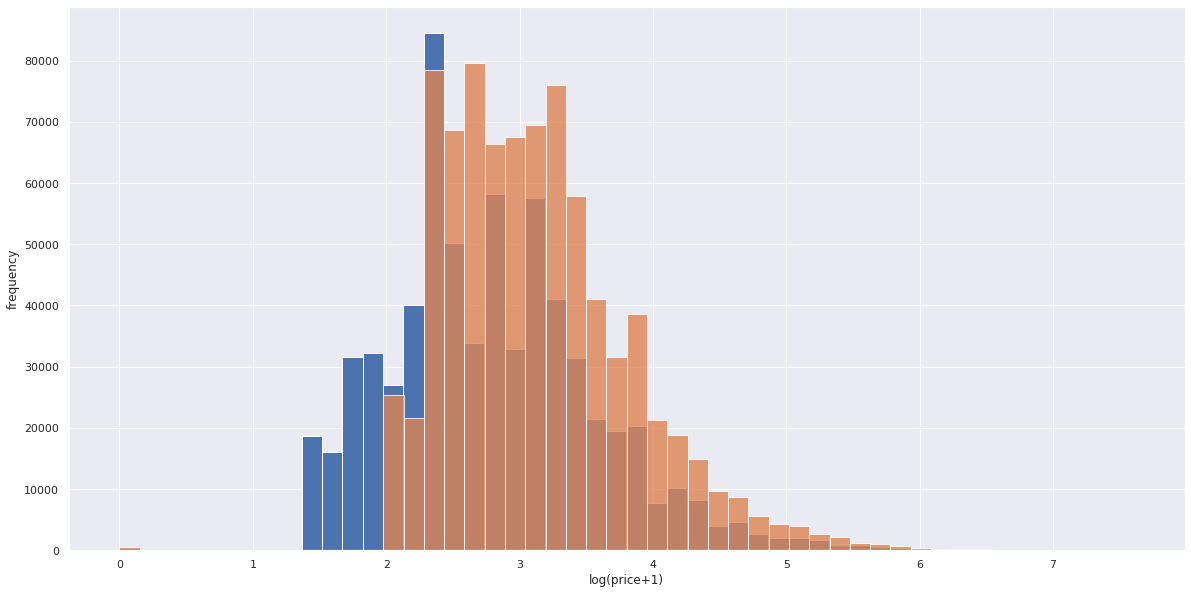

In [33]:
price_by_seller = train.loc[train.shipping == 1, "price"]
price_by_buyer = train.loc[train.shipping == 0, "price"]

fig, ax = plt.subplots(figsize=(20, 10))
ax.hist(np.log(price_by_seller+1), alpha=1.0, bins=50, label="Seller")
ax.hist(np.log(price_by_buyer+1), alpha=0.8, bins=50, label="Buyer")
plt.xlabel("log(price+1)")
plt.ylabel("frequency")
plt.show()

In [34]:
print("There are {} unique values in the category column.".format(train["category_name"].nunique()))

There are 1287 unique values in the category column.


In [35]:
train["category_name"].value_counts()[:5]

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
Name: category_name, dtype: int64

In [36]:
def split_cat(text):
    try: return text.split("/")
    except: return ("No label", "No label", "No label")
    
train["general_cat"], train["subcat_1"], train["subcat_2"] = \
zip(*train["category_name"].apply(lambda x: split_cat(x)))

train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [37]:
print("There are {} unique values in the general_category column.".format(train["general_cat"].nunique()))
print("There are {} unique values in the subcat_1 column.".format(train["subcat_1"].nunique()))
print("There are {} unique values in the subcat_2 column.".format(train["subcat_2"].nunique()))

There are 11 unique values in the general_category column.
There are 114 unique values in the subcat_1 column.
There are 871 unique values in the subcat_2 column.


In [38]:
x = train["general_cat"].value_counts().index.values.astype("str")
y = train["general_cat"].value_counts().values
pct = [("%.2f"%(v*100))+"%"for v in (y/len(train))]

In [19]:
trace1 = go.Bar(x=x, y=y, text=pct)
layout = dict(title="Number of Items by Main Category",
             yaxis = dict(title="Count"),
             xaxis = dict(title="Category"))
fig = dict(data=[trace1], layout=layout)
#py.iplot(fig):グイグイ動かせるそうです

In [39]:
print("There are {} unique brand names in the trainig dataset".format(train["brand_name"].nunique()))

There are 4809 unique brand names in the trainig dataset


In [3]:
def wordCount(text):
    # convert to lower case and strip regex
    try:
         # convert to lower case and strip regex
        text = text.lower()
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        txt = regex.sub(" ", text)
        # tokenize
        # words = nltk.word_tokenize(clean_txt)
        # remove words in stop words
        words = [w for w in txt.split(" ") \
                 if not w in stop_words.ENGLISH_STOP_WORDS and len(w)>3]
        return len(words)
    except: 
        return 0

In [4]:
train['desc_len'] = train['item_description'].apply(lambda x: wordCount(x))
test['desc_len'] = test['item_description'].apply(lambda x: wordCount(x))

In [5]:
print(train.item_description.isnull().sum())
train = train[pd.notnull(train["item_description"])]

4


In [6]:
stop = set(stopwords.words('english'))
def tokenize(text):
    """
    sent_tokenize(): segment text into sentences
    word_tokenize(): break sentences into words
    """
    try: 
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        text = regex.sub(" ", text) # remove punctuation
        
        tokens_ = [word_tokenize(s) for s in sent_tokenize(text)]
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent
        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
        filtered_tokens = [w.lower() for w in filtered_tokens if len(w)>=3]
        
        return filtered_tokens
            
    except TypeError as e: print(text,e)

In [7]:
train["tokens"] = train["item_description"].map(tokenize)

In [8]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,desc_len,tokens
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,1,"[description, yet]"
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,14,"[keyboard, great, condition, works, like, came..."
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,8,"[adorable, top, hint, lace, key, hole, back, p..."
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,14,"[new, tags, leather, horses, retail, stand, fo..."
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,3,"[complete, certificate, authenticity]"
